In [1]:
from itertools import product

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import RandomNormal


import sys
sys.path.append('../src')
import models
import viz

np.random.seed(4)
tf.random.set_seed(400)
tf.keras.backend.set_floatx('float64')

Text(0, 0.5, 'Weight in lbs')

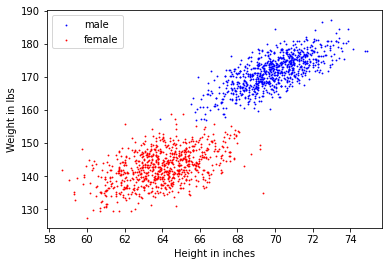

In [2]:
m_cov = np.array([[3,7],[7,29]])
m_m = np.array([70,172])
f_cov = np.array([[3.5,5],[5,29]])
f_m = np.array([64,143])
mhw = np.random.multivariate_normal(m_m, m_cov, 800)
fhw = np.random.multivariate_normal(f_m, f_cov, 800)
plt.scatter(mhw[:,0], mhw[:,1], color='blue', s=.7, label = 'male')
plt.scatter(fhw[:,0], fhw[:,1], color='red', s=.7, label = 'female')
plt.legend()
plt.xlabel('Height in inches')
plt.ylabel('Weight in lbs')

Text(0.5, 0, 'Height in inches')

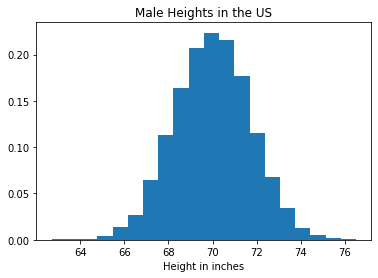

In [3]:
mhw = np.random.multivariate_normal(m_m, m_cov, 10000)
fhw = np.random.multivariate_normal(f_m, f_cov, 10000)

plt.hist(mhw[:,0], bins=20, density=True)
plt.title('Male Heights in the US')
plt.xlabel('Height in inches')

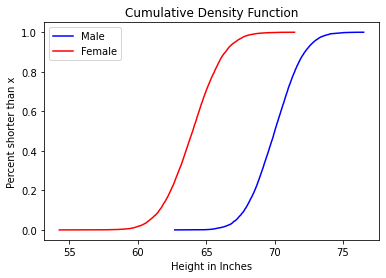

In [4]:
mh_sorted = np.sort(mhw[:,0])
mh_cdf = (np.ones(mhw.shape[0])/mhw.shape[0]).cumsum()
fh_sorted = np.sort(fhw[:,0])
fh_cdf = (np.ones(fhw.shape[0])/fhw.shape[0]).cumsum()
plt.plot(mh_sorted, mh_cdf, color='blue', label='Male')
plt.plot(fh_sorted, fh_cdf, color='red', label='Female')
plt.title('Cumulative Density Function')
plt.xlabel('Height in Inches')
plt.ylabel('Percent shorter than x')
plt.legend()

Text(0.5, 0, 'Percent shorter than x')

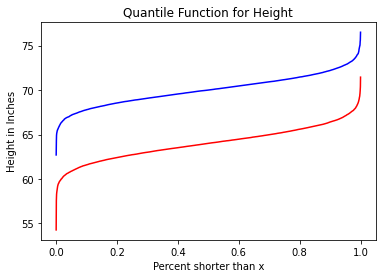

In [5]:
plt.plot(mh_cdf, mh_sorted, color='blue', label='Male')
plt.plot(fh_cdf, fh_sorted, color='red', label='Female')
plt.title('Quantile Function for Height')
plt.ylabel('Height in Inches')
plt.xlabel('Percent shorter than x')

# 1-D generator
A generator that generates simply male heights

In [6]:
tf.random.set_seed(111)

big_init = RandomNormal(mean=40, stddev=20)

inputs3 = Input(shape=(1), name='disc_in')
mid3 = Dense(20, activation='elu', name='disc_mid')(inputs3)
outputs3 = Dense(1, activation='sigmoid', name='disc_out')(mid3)

discriminator = Model(inputs3, outputs3)

inputs2 = Input(shape=(1), name='gen_in')
mid = Dense(10,
            activation='relu',
            kernel_initializer=big_init,
            bias_initializer=big_init,
            name='gen_mid'
           )(inputs2)
outputs2 = Dense(1, activation='linear', name='gen_out')(mid)

generator = Model(inputs2, outputs2)

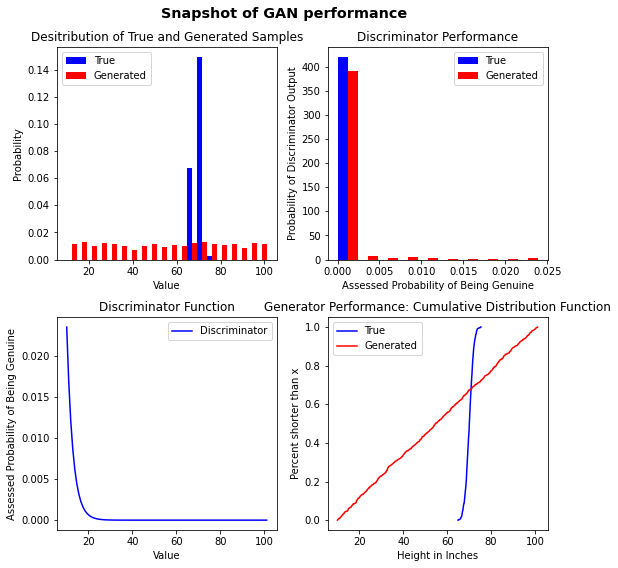

In [7]:
real_samples = mhw[:1000,:1]
viz.quad_plot_GAN(real_samples, generator, discriminator)

In [8]:
discriminator.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy')
generator.compile(optimizer=Adam(lr=1e-2), loss=models.early_gen_loss(discriminator))

In [9]:
fake_samples = generator(np.random.rand(1000,1))
el = models.early_gen_loss(discriminator)(1, fake_samples)
ll = models.late_gen_loss(discriminator)(1, fake_samples)
print(el.numpy().mean())
print(ll.numpy().mean())

19.914390207347736
-0.0006976329726033872


### 1. Train the Discriminator

In [10]:
batch_size = 10000
epoch_size = mhw.shape[0]
n_epochs = 1
sample_order = np.random.permutation(epoch_size)

for epoch in range(n_epochs):
    batch_list = range(epoch_size//batch_size)
    for batch in batch_list:
        print(f'Epoch: {epoch};  Batch : {batch}')
        noise = np.random.rand(batch_size,1)
        fake_samples = generator.predict(noise)
        fake_labels = np.zeros((batch_size)).reshape((-1,1))
        
        sample_indexes = sample_order[batch_size*batch:batch_size*(batch+1)]
        true_samples = mhw[sample_indexes,0].reshape((-1,1))
        true_labels = np.ones((batch_size)).reshape((-1,1))
        
        all_samples = np.concatenate((fake_samples, true_samples), 0)
        all_labels = np.concatenate((fake_labels, true_labels), 0)

        discriminator.fit(all_samples, all_labels, batch_size=10000, epochs=800)
#         generator.fit(noise, true_labels, epochs=1)

Epoch: 0;  Batch : 0
Train on 20000 samples
Epoch 1/800
20000/20000 [==============================] - 0s 21us/sample - loss: 11.2065
Epoch 2/800
20000/20000 [==============================] - 0s 1us/sample - loss: 5.3189
Epoch 3/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.4060
Epoch 4/800
20000/20000 [==============================] - 0s 1us/sample - loss: 3.5112
Epoch 5/800
20000/20000 [==============================] - 0s 1us/sample - loss: 4.1297
Epoch 6/800
20000/20000 [==============================] - 0s 1us/sample - loss: 3.3219
Epoch 7/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.6477
Epoch 8/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.0860
Epoch 9/800
20000/20000 [==============================] - 0s 1us/sample - loss: 2.1443
Epoch 10/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.7669
Epoch 11/800
20000/20000 [==============================] - 0s 1us/sample

20000/20000 [==============================] - 0s 1us/sample - loss: 0.5973
Epoch 93/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5968
Epoch 94/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5963
Epoch 95/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5960
Epoch 96/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5955
Epoch 97/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5950
Epoch 98/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5946
Epoch 99/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5942
Epoch 100/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5937
Epoch 101/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5933
Epoch 102/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5929
Epoch 103/800
20000/20000 [====

20000/20000 [==============================] - 0s 1us/sample - loss: 0.5424
Epoch 183/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5417
Epoch 184/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5408
Epoch 185/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5402
Epoch 186/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5392
Epoch 187/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5387
Epoch 188/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5378
Epoch 189/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5377
Epoch 190/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5364
Epoch 191/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.5350
Epoch 192/800
20000/20000 [==============================] - 0s 0us/sample - loss: 0.5344
Epoch 193/800
20000/2000

20000/20000 [==============================] - 0s 1us/sample - loss: 0.4647
Epoch 274/800
20000/20000 [==============================] - 0s 0us/sample - loss: 0.4648
Epoch 275/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4635
Epoch 276/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4626
Epoch 277/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4624
Epoch 278/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4608
Epoch 279/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4608
Epoch 280/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4588
Epoch 281/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4579
Epoch 282/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4571
Epoch 283/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.4563
Epoch 284/800
20000/2000

20000/20000 [==============================] - 0s 1us/sample - loss: 0.3938
Epoch 365/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3923
Epoch 366/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3916
Epoch 367/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3909
Epoch 368/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3905
Epoch 369/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3899
Epoch 370/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3896
Epoch 371/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3888
Epoch 372/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3877
Epoch 373/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3877
Epoch 374/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3871
Epoch 375/800
20000/2000

20000/20000 [==============================] - 0s 1us/sample - loss: 0.3386
Epoch 456/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3396
Epoch 457/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3382
Epoch 458/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3374
Epoch 459/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3378
Epoch 460/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3381
Epoch 461/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3365
Epoch 462/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3382
Epoch 463/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3361
Epoch 464/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3348
Epoch 465/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3351
Epoch 466/800
20000/2000

20000/20000 [==============================] - 0s 1us/sample - loss: 0.3039
Epoch 547/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3020
Epoch 548/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3055
Epoch 549/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3015
Epoch 550/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3027
Epoch 551/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3005
Epoch 552/800
20000/20000 [==============================] - ETA: 0s - loss: 0.301 - 0s 1us/sample - loss: 0.3000
Epoch 553/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3002
Epoch 554/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3010
Epoch 555/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.3000
Epoch 556/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2989


20000/20000 [==============================] - 0s 1us/sample - loss: 0.2789
Epoch 637/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2789
Epoch 638/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2801
Epoch 639/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2785
Epoch 640/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2784
Epoch 641/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2789
Epoch 642/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2817
Epoch 643/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2804
Epoch 644/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2783
Epoch 645/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2779
Epoch 646/800
20000/20000 [==============================] - 0s 2us/sample - loss: 0.2791
Epoch 647/800
20000/2000

20000/20000 [==============================] - 0s 1us/sample - loss: 0.2707
Epoch 727/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2784
Epoch 728/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2759
Epoch 729/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2711
Epoch 730/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2822
Epoch 731/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2785
Epoch 732/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2706
Epoch 733/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2749
Epoch 734/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2699
Epoch 735/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2626
Epoch 736/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.2619
Epoch 737/800
20000/2000

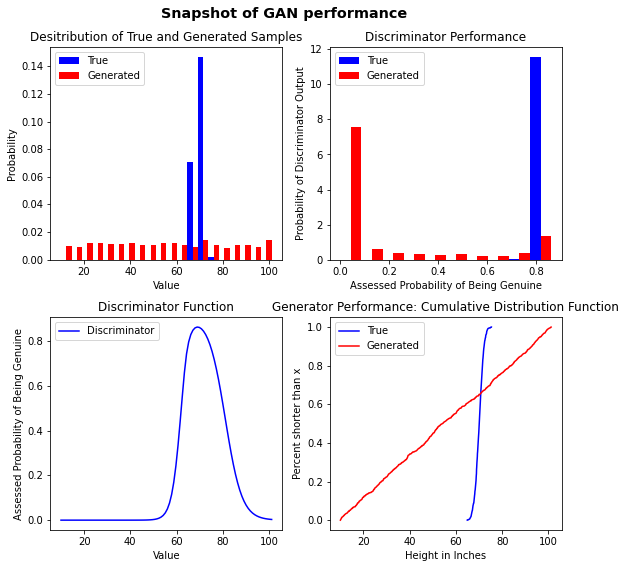

In [11]:
real_samples = mhw[:1000,:1]
viz.quad_plot_GAN(real_samples, generator, discriminator)

### 2. Train Generator

In [12]:
batch_size = 10000
epoch_size = mhw.shape[0]
n_epochs = 1
sample_order = np.random.permutation(epoch_size)

for epoch in range(n_epochs):
    batch_list = range(epoch_size//batch_size)
    for batch in batch_list:
        print(f'Epoch: {epoch};  Batch : {batch}')
        noise = np.random.rand(batch_size,1)
        fake_samples = generator.predict(noise)
        fake_labels = np.zeros((batch_size)).reshape((-1,1))
        
        sample_indexes = sample_order[batch_size*batch:batch_size*(batch+1)]
        true_samples = mhw[sample_indexes,0].reshape((-1,1))
        true_labels = np.ones((batch_size)).reshape((-1,1))
        
        all_samples = np.concatenate((fake_samples, true_samples), 0)
        all_labels = np.concatenate((fake_labels, true_labels), 0)

#         discriminator.fit(all_samples, all_labels, batch_size=10000, epochs=500)
        generator.fit(noise, true_labels, batch_size=1000, epochs=10)

Epoch: 0;  Batch : 0
Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 0s 36us/sample - loss: 7.3043
Epoch 2/10
10000/10000 [==============================] - 0s 5us/sample - loss: 6.2470
Epoch 3/10
10000/10000 [==============================] - 0s 5us/sample - loss: 5.2971
Epoch 4/10
10000/10000 [==============================] - 0s 4us/sample - loss: 4.3509
Epoch 5/10
10000/10000 [==============================] - 0s 5us/sample - loss: 3.4262
Epoch 6/10
10000/10000 [==============================] - 0s 5us/sample - loss: 2.5211
Epoch 7/10
10000/10000 [==============================] - 0s 6us/sample - loss: 1.6860
Epoch 8/10
10000/10000 [==============================] - 0s 4us/sample - loss: 0.9892
Epoch 9/10
10000/10000 [==============================] - 0s 5us/sample - loss: 0.5145
Epoch 10/10
10000/10000 [==============================] - 0s 5us/sample - loss: 0.2829


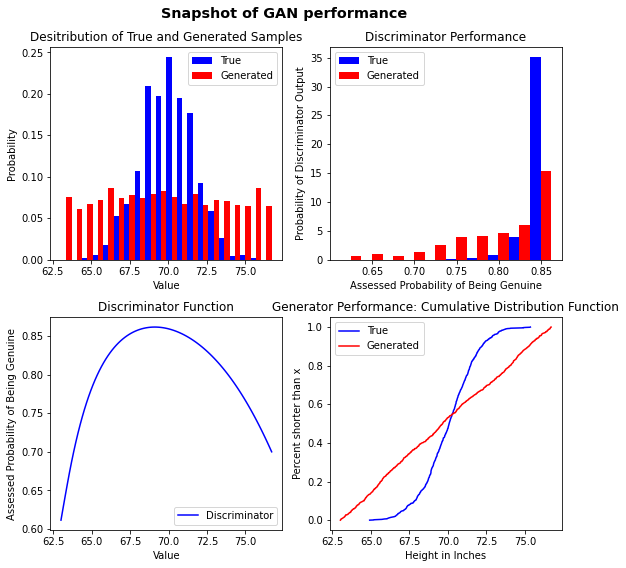

In [13]:
real_samples = mhw[:1000,:1]
viz.quad_plot_GAN(real_samples, generator, discriminator)

In [14]:
fake_samples = generator(np.random.rand(1000,1))
el = models.early_gen_loss(discriminator)(1, fake_samples)
ll = models.late_gen_loss(discriminator)(1, fake_samples)
print(el.numpy().mean())
print(ll.numpy().mean())

0.22336395460147826
-1.6635046698904465


### 3. Be safe, and train both

In [20]:
sgd = discriminator.optimizer
sgd.weights

[<tf.Variable 'SGD/iter:0' shape=() dtype=int64, numpy=1600>]

In [21]:
discriminator.compile(optimizer=SGD(lr=1e-3), loss='binary_crossentropy')
generator.compile(optimizer=SGD(lr=1e-4), loss=models.early_gen_loss(discriminator))

In [15]:
batch_size = 10000
epoch_size = mhw.shape[0]
n_epochs = 1
sample_order = np.random.permutation(epoch_size)

for epoch in range(n_epochs):
    batch_list = range(epoch_size//batch_size)
    for batch in batch_list:
        print(f'Epoch: {epoch};  Batch : {batch}')
        noise = np.random.rand(batch_size,1)
        fake_samples = generator.predict(noise)
        fake_labels = np.zeros((batch_size)).reshape((-1,1))
        
        sample_indexes = sample_order[batch_size*batch:batch_size*(batch+1)]
        true_samples = mhw[sample_indexes,0].reshape((-1,1))
        true_labels = np.ones((batch_size)).reshape((-1,1))
        
        all_samples = np.concatenate((fake_samples, true_samples), 0)
        all_labels = np.concatenate((fake_labels, true_labels), 0)

        discriminator.fit(all_samples, all_labels, batch_size=10000, epochs=1000)
#         generator.fit(noise, true_labels, batch_size=1000, epochs=1)

Epoch: 0;  Batch : 0
Train on 20000 samples
Epoch 1/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 2.1696
Epoch 2/1000
20000/20000 [==============================] - 0s 0us/sample - loss: 1.6486
Epoch 3/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 2.0500
Epoch 4/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 1.9123
Epoch 5/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 2.2938
Epoch 6/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 1.7969
Epoch 7/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 1.3442
Epoch 8/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 1.3792
Epoch 9/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 1.2419
Epoch 10/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 1.2114
Epoch 11/1000
20000/20000 [==============================] - 0s 1

20000/20000 [==============================] - 0s 1us/sample - loss: 0.7386
Epoch 182/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7209
Epoch 183/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7248
Epoch 184/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7215
Epoch 185/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7290
Epoch 186/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7205
Epoch 187/1000
20000/20000 [==============================] - 0s 0us/sample - loss: 0.7349
Epoch 188/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7204
Epoch 189/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7201
Epoch 190/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7274
Epoch 191/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7209
Epoch 192/1000

Epoch 271/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7076
Epoch 272/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7089
Epoch 273/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7076
Epoch 274/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7076
Epoch 275/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7163
Epoch 276/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7100
Epoch 277/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7114
Epoch 278/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7078
Epoch 279/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7158
Epoch 280/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7149
Epoch 281/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7072

20000/20000 [==============================] - 0s 1us/sample - loss: 0.7009
Epoch 362/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7022
Epoch 363/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7051
Epoch 364/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7024
Epoch 365/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7071
Epoch 366/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7132
Epoch 367/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7018
Epoch 368/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7034
Epoch 369/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7058
Epoch 370/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7109
Epoch 371/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7011
Epoch 372/1000

Epoch 451/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7000
Epoch 452/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7112
Epoch 453/1000
20000/20000 [==============================] - 0s 0us/sample - loss: 0.6996
Epoch 454/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7106
Epoch 455/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7004
Epoch 456/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7301
Epoch 457/1000
20000/20000 [==============================] - 0s 0us/sample - loss: 0.7022
Epoch 458/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7219
Epoch 459/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7032
Epoch 460/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7214
Epoch 461/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7026

20000/20000 [==============================] - 0s 0us/sample - loss: 0.6982
Epoch 542/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6943
Epoch 543/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6971
Epoch 544/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7226
Epoch 545/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7113
Epoch 546/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6958
Epoch 547/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6957
Epoch 548/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6944
Epoch 549/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6948
Epoch 550/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6951
Epoch 551/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6945
Epoch 552/1000

20000/20000 [==============================] - 0s 1us/sample - loss: 0.6936
Epoch 721/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6930
Epoch 722/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6930
Epoch 723/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6930
Epoch 724/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6930
Epoch 725/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6955
Epoch 726/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6961
Epoch 727/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6980
Epoch 728/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7021
Epoch 729/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6935
Epoch 730/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6975
Epoch 731/1000

Epoch 810/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6938
Epoch 811/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6923
Epoch 812/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6925
Epoch 813/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6944
Epoch 814/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6933
Epoch 815/1000
20000/20000 [==============================] - 0s 0us/sample - loss: 0.6926
Epoch 816/1000
20000/20000 [==============================] - 0s 0us/sample - loss: 0.6998
Epoch 817/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7002
Epoch 818/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6932
Epoch 819/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6922
Epoch 820/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6930

20000/20000 [==============================] - 0s 1us/sample - loss: 0.6925
Epoch 901/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6966
Epoch 902/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6959
Epoch 903/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6923
Epoch 904/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6942
Epoch 905/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6922
Epoch 906/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6946
Epoch 907/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6942
Epoch 908/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6918
Epoch 909/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6919
Epoch 910/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6929
Epoch 911/1000

Epoch 990/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6919
Epoch 991/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6921
Epoch 992/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6919
Epoch 993/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6921
Epoch 994/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6979
Epoch 995/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6954
Epoch 996/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7022
Epoch 997/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7037
Epoch 998/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.6933
Epoch 999/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.7000
Epoch 1000/1000
20000/20000 [==============================] - 0s 1us/sample - loss: 0.692

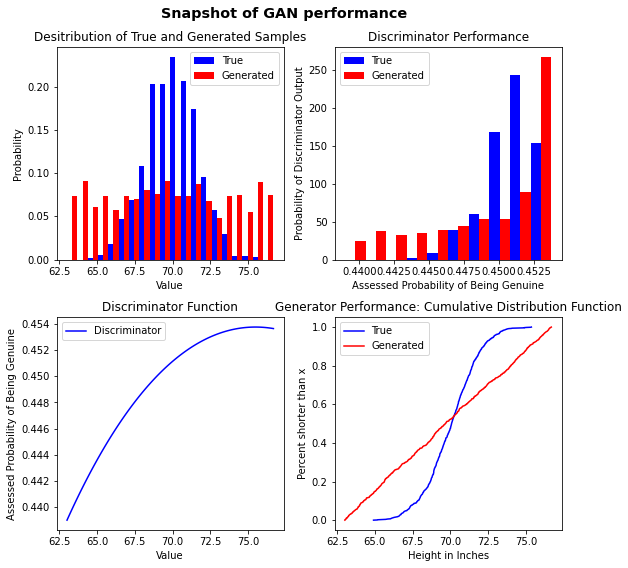

In [16]:
real_samples = mhw[:1000,:1]
viz.quad_plot_GAN(real_samples, generator, discriminator)

In [20]:
discriminator.compile(optimizer=SGD(lr=1e-3), loss='binary_crossentropy')
generator.compile(optimizer=Adam(lr=1e-2), loss=models.late_gen_loss(discriminator))

In [21]:
batch_size = 10000
epoch_size = mhw.shape[0]
n_epochs = 1
sample_order = np.random.permutation(epoch_size)

for epoch in range(n_epochs):
    batch_list = range(epoch_size//batch_size)
    for batch in batch_list:
        print(f'Epoch: {epoch};  Batch : {batch}')
        noise = np.random.rand(batch_size,1)
        fake_samples = generator.predict(noise)
        fake_labels = np.zeros((batch_size)).reshape((-1,1))
        
        sample_indexes = sample_order[batch_size*batch:batch_size*(batch+1)]
        true_samples = mhw[sample_indexes,0].reshape((-1,1))
        true_labels = np.ones((batch_size)).reshape((-1,1))
        
        all_samples = np.concatenate((fake_samples, true_samples), 0)
        all_labels = np.concatenate((fake_labels, true_labels), 0)

        discriminator.fit(all_samples, all_labels, batch_size=10000, epochs=800)
        generator.fit(noise, true_labels, batch_size=1000, epochs=1)

Epoch: 0;  Batch : 0
Train on 20000 samples
Epoch 1/800
20000/20000 [==============================] - 0s 9us/sample - loss: 1.0615
Epoch 2/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.6432
Epoch 3/800
20000/20000 [==============================] - 0s 1us/sample - loss: 2.1417
Epoch 4/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.4169
Epoch 5/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.3856
Epoch 6/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.3784
Epoch 7/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.3661
Epoch 8/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.3471
Epoch 9/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.3149
Epoch 10/800
20000/20000 [==============================] - 0s 1us/sample - loss: 1.2439
Epoch 11/800
20000/20000 [==============================] - 0s 1us/sample -

Epoch 183/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0097
Epoch 184/800
20000/20000 [==============================] - 0s 0us/sample - loss: 0.0097
Epoch 185/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0097
Epoch 186/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0097
Epoch 187/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0097
Epoch 188/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0096
Epoch 189/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0096
Epoch 190/800
20000/20000 [==============================] - 0s 0us/sample - loss: 0.0096
Epoch 191/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0096
Epoch 192/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0096
Epoch 193/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0096
Epoch 194/

20000/20000 [==============================] - 0s 0us/sample - loss: 0.0084
Epoch 275/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0084
Epoch 276/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0084
Epoch 277/800
20000/20000 [==============================] - 0s 0us/sample - loss: 0.0084
Epoch 278/800
20000/20000 [==============================] - 0s 0us/sample - loss: 0.0084
Epoch 279/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0083
Epoch 280/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0083
Epoch 281/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0083
Epoch 282/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0083
Epoch 283/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0083
Epoch 284/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0083
Epoch 285/800
20000/2000

20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 456/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 457/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 458/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 459/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 460/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 461/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 462/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 463/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 464/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0037
Epoch 465/800
20000/20000 [==============================] - 0s 0us/sample - loss: 0.0037
Epoch 466/800
20000/2000

20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 638/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 639/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 640/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 641/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 642/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 643/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 644/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 645/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 646/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 647/800
20000/20000 [==============================] - 0s 1us/sample - loss: 0.0033
Epoch 648/800
20000/2000

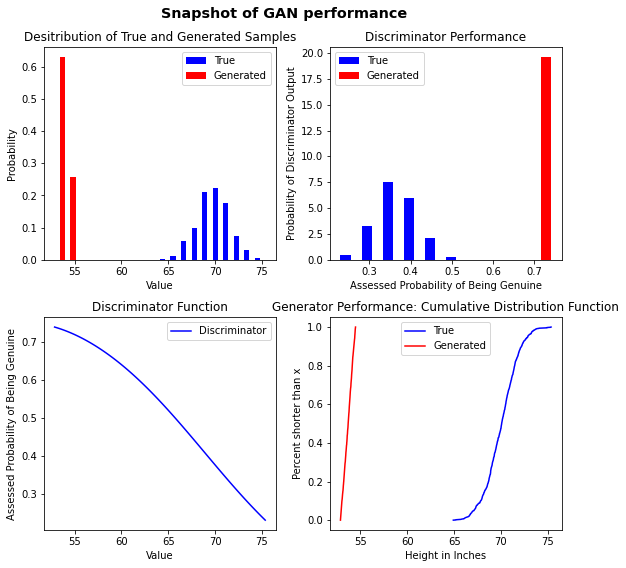

In [19]:
real_samples = mhw[:1000,:1]
viz.quad_plot_GAN(real_samples, generator, discriminator)

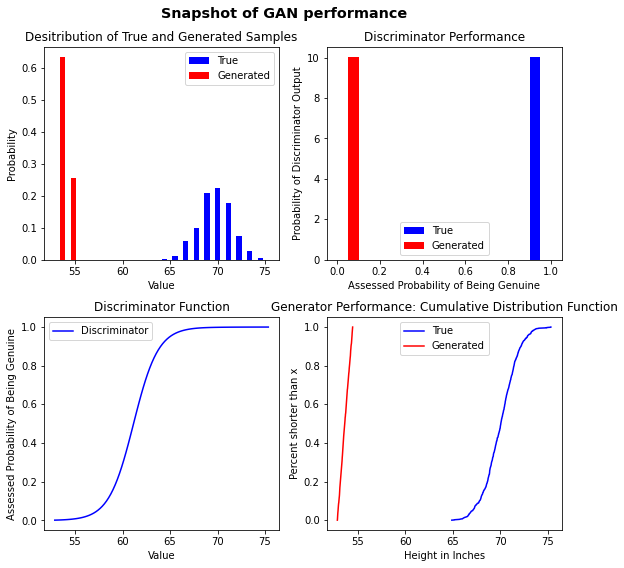

In [22]:
real_samples = mhw[:1000,:1]
viz.quad_plot_GAN(real_samples, generator, discriminator)

# 2D Generator

In [ ]:
# 2-D generator
A generator for height-weight combinations

In [9]:
def mhw_generator(arr: np.ndarray) -> np.ndarray:
    shape = arr.shape
    pred = np.empty((len(arr),2))
    for i in range(len(arr)):
        pred[i,:] = np.random.multivariate_normal(mean=[68,160],cov=[[2,-3],[-3,10]])
    return pred

In [10]:
m_gen_hw = mhw_generator(inputs)

Text(0, 0.5, 'Weight in lbs')

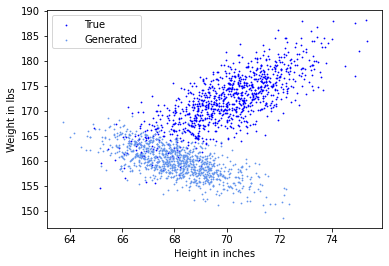

In [11]:
n_dots = 1000
plt.scatter(mhw[:n_dots,0], mhw[:n_dots,1], s=.6, color='blue', label = 'True')
plt.scatter(m_gen_hw[:n_dots,0], m_gen_hw[:n_dots,1], s=.6, color='cornflowerblue', label = 'Generated')
plt.legend()
plt.xlabel('Height in inches')
plt.ylabel('Weight in lbs')

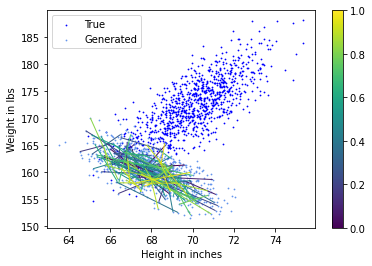

In [12]:
def test_gen_1dto2d(real: np.ndarray, generator, skip: int=10):
    uniform_scale = np.linspace(0,1,1001)
    generated_scale = generator(uniform_scale)

    n_dots = 1000
    skip = 10
    points = generated_scale.reshape(-1,1,2)
    segments = np.concatenate([points[:n_dots-1:skip], points[1:n_dots:skip]],
                              axis=1)
    lc = LineCollection(segments, cmap='viridis')
    lc.set_array(uniform_scale[::skip])
    lc.set_linewidth(1)


    fig = plt.figure()
    ax = plt.gca()
    line = ax.add_collection(lc)

    plt.scatter(real[:n_dots,0], real[:n_dots,1], s=.6, color='blue',
                label = 'True')
    plt.scatter(generated_scale[:n_dots,0], generated_scale[:n_dots,1], s=.6, 
                color='cornflowerblue', label = 'Generated')
    plt.legend()
    plt.xlabel('Height in inches')
    plt.ylabel('Weight in lbs')

    fig.colorbar(line, ax=ax)
test_gen_1dto2d(mhw, mhw_generator, 10)

In [13]:
# Code to implement a GAN with 2-D output

# Conditional Generator
A generator for male or height-weight combinations

In [14]:
def hw_generator(arr: np.ndarray, sex: str) -> np.ndarray:
    shape = arr.shape
    pred = np.empty((len(arr),2))
    if sex == 'male':
        for i in range(len(arr)):
            pred[i,:] = np.random.multivariate_normal(mean=[68,160],cov=[[2,-3],[-3,10]])
    if sex == 'female':
        for i in range(len(arr)):
            pred[i,:] = np.random.multivariate_normal(mean=[71,150],cov=[[2,0],[0,7]])
    return pred

In [15]:
m_gen_hw2 = hw_generator(inputs[::2], 'male')
f_gen_hw = hw_generator(inputs[1::2], 'female')
gen_hw = np.stack((m_gen_hw2, f_gen_hw))

Text(0, 0.5, 'Weight in lbs')

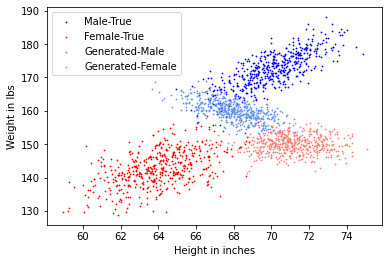

In [16]:
n_dots = 500
plt.scatter(mhw[:n_dots,0], mhw[:n_dots,1], s=.6, color='blue', label = 'Male-True')
plt.scatter(fhw[:n_dots,0], fhw[:n_dots,1], s=.6, color='red', label = 'Female-True')
plt.scatter(gen_hw[0,:n_dots,0], gen_hw[0,:n_dots,1], s=.6, color='cornflowerblue', label = 'Generated-Male')
plt.scatter(gen_hw[1,:n_dots,0], gen_hw[1,:n_dots,1], s=.6, color='salmon', label = 'Generated-Female')
plt.legend()
plt.xlabel('Height in inches')
plt.ylabel('Weight in lbs')

In [17]:
# Code to implement a Conditional GAN with 2-D output